In [78]:
import krippendorff
import numpy as np
import json   
from pathlib import Path
import matplotlib.pyplot as plt

# Paths

In [ ]:
gt_annotations_path = Path("/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/511_test_documents_educational_content_human_as_a_judge/human_raw_scores/annotations__educational_content__en__gt.jsonl")
en_documents_path = Path("/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/511_test_documents_educational_content_human_as_a_judge/human_aggregated_scores/511_test_documents_educational_content_en.jsonl")

# Human Annotations

In [28]:
def load_gt_annotations(jsonl_path: Path):
    scores = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            obj = json.loads(line)
            row = obj.get("scores")
            cleaned = [int(x) if x is not None else None for x in row]
            if cleaned:  # ensure it’s not empty
                scores.append(cleaned)
    return scores

def load_documents(jsonl_path: Path):
    documents = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            obj = json.loads(line)
            documents.append(obj)
    return documents

### Krippendorf Alpha

In [13]:
# Transpose data to shape (annotator, item)
def compute_krippendorff_alpha(annotations):
    data = np.array(annotations).T
    alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='interval')
    return alpha

In [ ]:
jsonl_path = "annotations__educational_content__en__gt.jsonl"
annotations = load_gt_annotations(jsonl_path)
alpha = compute_krippendorff_alpha(annotations)
print(f"Krippendorff’s alpha (ordinal): {alpha:.3f}")

Krippendorff’s alpha (ordinal): 0.569


### Standard Deviation

In [72]:
gt_annotations = load_gt_annotations(gt_annotations_path)
np.array(gt_annotations).std(axis=1).mean()


np.float64(0.5627472794400139)

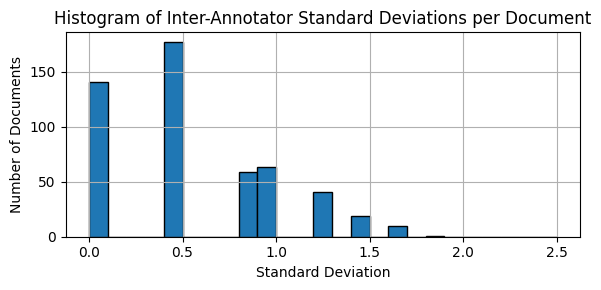

In [93]:
per_doc_stds = np.std(gt_annotations, axis=1, ddof=0)

# Plot histogram
plt.figure(figsize=(6, 3))
plt.hist(per_doc_stds, bins=np.linspace(0, 2.5, 26), edgecolor='black')
plt.title('Histogram of Inter-Annotator Standard Deviations per Document')
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.tight_layout()
plt.show()

### Spread

In [66]:
k = 10
spread = np.array(gt_annotations).max(axis=1) - np.array(gt_annotations).min(axis=1)

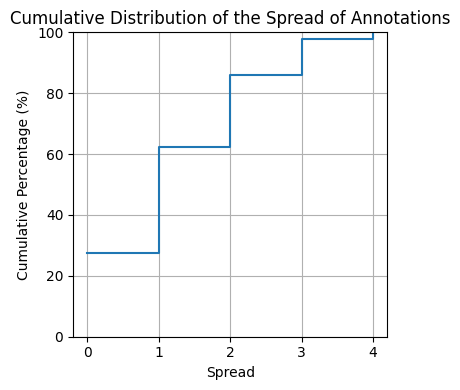

In [77]:

# Sort the data
sorted_arr = np.sort(spread)

# Unique values and their cumulative percentages
values = np.unique(sorted_arr)
cdf = [np.mean(spread <= v) * 100 for v in values]  # percentage of elements ≤ v

# Plot CDF
plt.figure(figsize=(4, 4))
plt.ylim(0, 100)
plt.step(values, cdf, where="post")
plt.xlabel("Spread")
plt.ylabel("Cumulative Percentage (%)")
plt.title("Cumulative Distribution of the Spread of Annotations")
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
top_k_spread_doc_ids = spread.argsort()[::-1][:k]

In [70]:
# documents with largest spread

documents = load_documents(en_documents_path)
for doc_id in list(top_k_spread_doc_ids):
    document = documents[doc_id]
    print(f"Document ID 1: {doc_id}")
    print(f"Document ID 2: {document['document_id']}")
    print(f"Scores: {gt_annotations[doc_id]}")
    print(f"Text: {document['text']}")
    print("========================================================================================================")

Document ID 1: 2
Document ID 2: 2
Scores: [4, 1, 0]
Text: Music and Concerts Math
This worksheet is themed around music and concerts, featuring math word problems that incorporate elements of musical performances, ticket sales, and concert logistics. Students are tasked with solving problems that include calculating the average number of songs played at concerts, dividing attendees among stages, and determining the distribution of time for music lessons. The worksheet uses real-life scenarios from the music industry to make math problems more engaging and relevant to students who may have an interest in music. Colorful, music-related illustrations are used to visually enhance the problems, adding to the educational appeal of the worksheet.
The worksheet is designed to teach students how to apply division and other mathematical operations to situations they might encounter in the context of music and concerts. By solving these problems, students practice dividing quantities evenly, calc

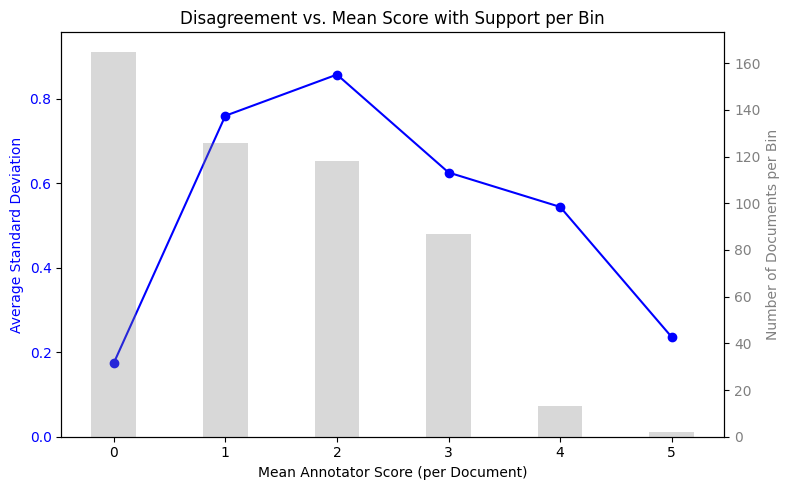

In [91]:

import numpy as np
import matplotlib.pyplot as plt

# Load your annotation data
# Replace this with your actual loading logic
# gt_annotations = load_gt_annotations(gt_annotations_path)
# Ensure it's a NumPy array of shape (num_docs, 3)
gt_annotations = np.array(gt_annotations)

# Compute mean and standard deviation per document
means = np.mean(gt_annotations, axis=1)
stds = np.std(gt_annotations, axis=1, ddof=0)

# Bin the mean scores
bins = np.arange(-0.5, 6, 1)  # Bins: [0.0, 0.5), [0.5, 1.0), ..., [5.0, 5.5)
bin_indices = np.digitize(means, bins)

# Calculate average std and support for each bin
avg_stds_per_bin = [np.mean(stds[bin_indices == i]) for i in range(1, len(bins))]
support_per_bin = [np.sum(bin_indices == i) for i in range(1, len(bins))]

# Compute bin centers for x-axis
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Line plot for average std dev
ax1.plot(bin_centers, avg_stds_per_bin, color='blue', marker='o', label='Avg Std Dev')
ax1.set_xlabel('Mean Annotator Score (per Document)')
ax1.set_ylabel('Average Standard Deviation', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, max(avg_stds_per_bin) + 0.1)

# Bar plot for support on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(bin_centers, support_per_bin, width=0.4, alpha=0.3, color='gray', label='Support (Count)')
ax2.set_ylabel('Number of Documents per Bin', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Title and layout
plt.title('Disagreement vs. Mean Score with Support per Bin')
fig.tight_layout()
plt.show()
